<a href="https://colab.research.google.com/github/Priya9112/Time-Series-Analysis-Final-Project/blob/main/01_DataPrep_ARIMA_GARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### DSCC 475 – Time-Series Analysis
## **Hybrid Deep Learning Framework for Stock Market Volatility Forecasting: Integrating ARIMA-GARCH-LSTM-Transformer Models with Macroeconomic Indicators**

"""
Notebook 1 — Data Preparation, Exploratory Analysis, ARIMA & GARCH

This notebook covers Weeks 1 and 2 of the project pipeline:
1. Load raw financial datasets (AAPL, TSLA, SPY)
2. Clean and preprocess data (DatetimeIndex, numeric corrections)
3. Compute engineered features:
     • Log Returns
     • 7-day and 21-day Rolling Volatility (target variable)
4. Perform Exploratory Data Analysis:
     • Price trends, volatility clustering
     • ADF stationarity tests
     • ACF/PACF diagnostics
5. Fit classical time-series models:
     • ARIMA for returns forecasting
     • GARCH(1,1) for volatility modeling
6. Generate forecasts and evaluate ARIMA/GARCH performance (RMSE, plots)

This notebook prepares all cleaned datasets and classical model outputs
needed for deep learning models (Week 3–4) and the Hybrid Ensemble.
"""


### Week 1

install packages and imports

In [ ]:
!pip uninstall -y jax jaxlib flax tf-keras tensorflow-probability tensorflow-text tensorstore keras-hub dopamine-rl yfinance numpy pandas protobuf ml_dtypes pmdarima arch requests jedi rich matplotlib seaborn statsmodels scipy >/dev/null 2>&1 || true

In [ ]:
!pip install --upgrade pip setuptools wheel >/dev/null 2>&1

!pip install -q \
  numpy==1.26.4 \
  scipy==1.10.1 \
  pandas==2.2.2 \
  statsmodels==0.14.3 \
  matplotlib==3.9.2 \
  seaborn==0.13.2 \
  yfinance==0.2.54 \
  requests==2.32.3 \
  rich==13.7.1 \
  jedi==0.19.1 \
  protobuf==5.26.1 \
  ml_dtypes==0.4.0

# Install arch FIRST (version 5.3.1 = stable)
!pip install -q arch==5.3.1

# Install pmdarima LAST (needs scipy + numpy already in place)
!pip install -q pmdarima==2.0.4

# Install TensorFlow after the above to avoid ABI conflicts
!pip install -q tensorflow==2.18.0


ERROR: Ignored the following yanked versions: 1.11.0, 1.14.0rc1
ERROR: Ignored the following versions that require a different python version: 1.10.0 Requires-Python >=3.8,<3.12; 1.10.0rc1 Requires-Python >=3.8,<3.12; 1.10.0rc2 Requires-Python >=3.8,<3.12; 1.10.1 Requires-Python >=3.8,<3.12; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11; 1.9.0 Requires-Python >=3.8,<3.12; 1.9.0rc1 Requires-Python >=3.8,<3.12; 1.9.0rc2 Requires-Python >=3.8,<3.12; 1.9.0rc3 Requires-Python >=3.8,<3.12; 1.9.1 Requires-Python >=3.8,<3.12
ERROR: Could not find a version that satisfies the requirement scipy==1.10.1 (from versions:

In [1]:
import tensorflow as tf, numpy as np, pandas as pd

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)


TensorFlow: 2.19.0
NumPy: 2.0.2
Pandas: 2.2.2


In [2]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Display settings
pd.options.display.float_format = '{:.6f}'.format
plt.style.use('seaborn-v0_8')

print("All libraries imported successfully and ready to use!")


All libraries imported successfully and ready to use!


Data download & initial inspection

In [3]:
import pandas as pd
import yfinance as yf

tickers = ['AAPL', 'TSLA', 'SPY']
start_date = '2015-01-01'
end_date = '2025-10-01'

data = {}
for t in tickers:
    try:
        df = yf.download(t, start=start_date, end=end_date, auto_adjust=True, threads=False, progress=False)
        if df.empty:
            print(f"Skipping {t}: No data returned.")
        else:
            df.index = pd.to_datetime(df.index)
            data[t] = df
            print(f"{t}: {len(df)} rows from {df.index.min().date()} to {df.index.max().date()}")
    except Exception as e:
        print(f"Failed to download {t}: {e}")

# Quick check for one
if 'AAPL' in data:
    display(data['AAPL'].head())


AAPL: 2702 rows from 2015-01-02 to 2025-09-30
TSLA: 2702 rows from 2015-01-02 to 2025-09-30
SPY: 2702 rows from 2015-01-02 to 2025-09-30


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.237555,24.705324,23.798604,24.694239,212818400
2015-01-05,23.554747,24.086807,23.368526,24.006998,257142000
2015-01-06,23.556957,23.816336,23.195599,23.619031,263188400
2015-01-07,23.887276,23.987036,23.654499,23.765345,160423600
2015-01-08,24.805084,24.862725,24.097887,24.215385,237458000


Compute returns & rolling volatility (primary target)

In [ ]:
import numpy as np

# Cell 3: Add log return and rolling volatility (window ~21 trading days)
for t, df in data.items():
    df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Volatility_21'] = df['LogReturn'].rolling(window=21).std()  # monthly rolling volatility
    df['Volatility_7'] = df['LogReturn'].rolling(window=7).std()    # weekly rolling volatility
    data[t] = df

# show stats for AAPL as sample
display(data['AAPL'][['Close','LogReturn','Volatility_21','Volatility_7']].tail(8))

Price,Close,LogReturn,Volatility_21,Volatility_7
Ticker,AAPL,,,
Date,,,,
2025-09-19,245.262238,0.031531,0.015251,0.011525
2025-09-22,255.831985,0.042193,0.017220,0.016480
2025-09-23,254.183594,-0.006464,0.017366,0.018342
2025-09-24,252.065643,-0.008367,0.017541,0.019895
2025-09-25,256.621216,0.017912,0.017745,0.020096
2025-09-26,255.212601,-0.005504,0.017904,0.020915
2025-09-29,254.183594,-0.004040,0.017981,0.020846
2025-09-30,254.383408,0.000786,0.017946,0.018572


Plot price & volatility time series

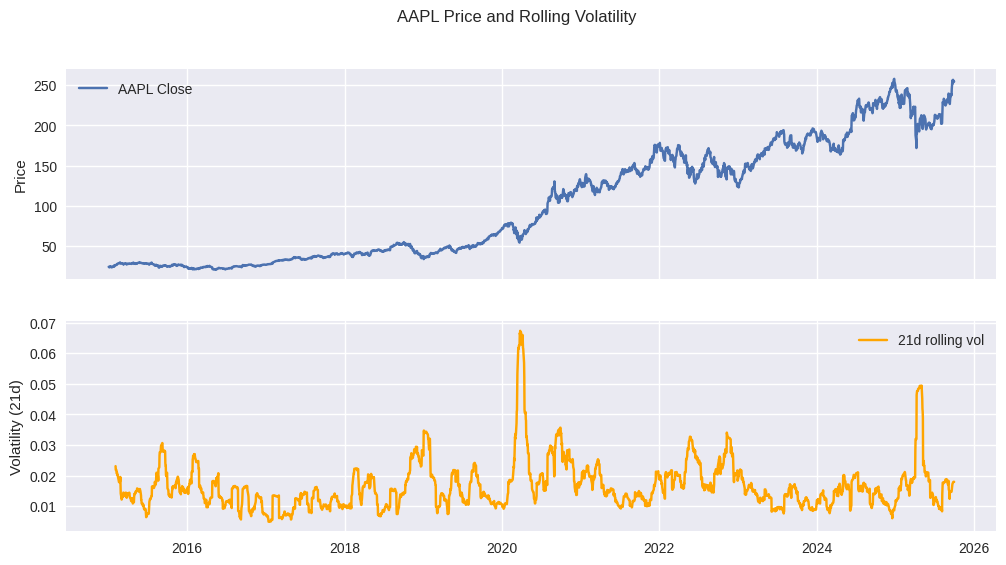

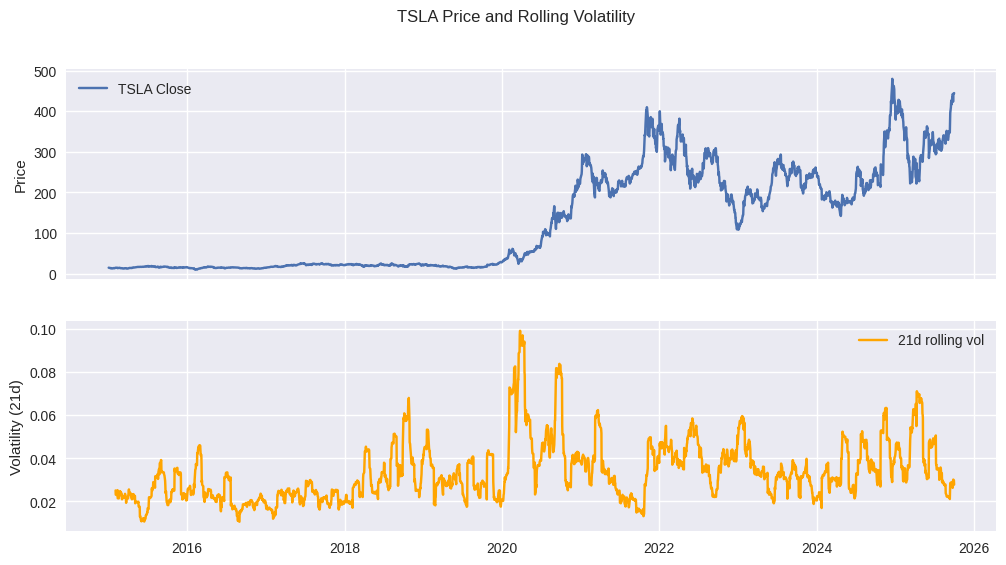

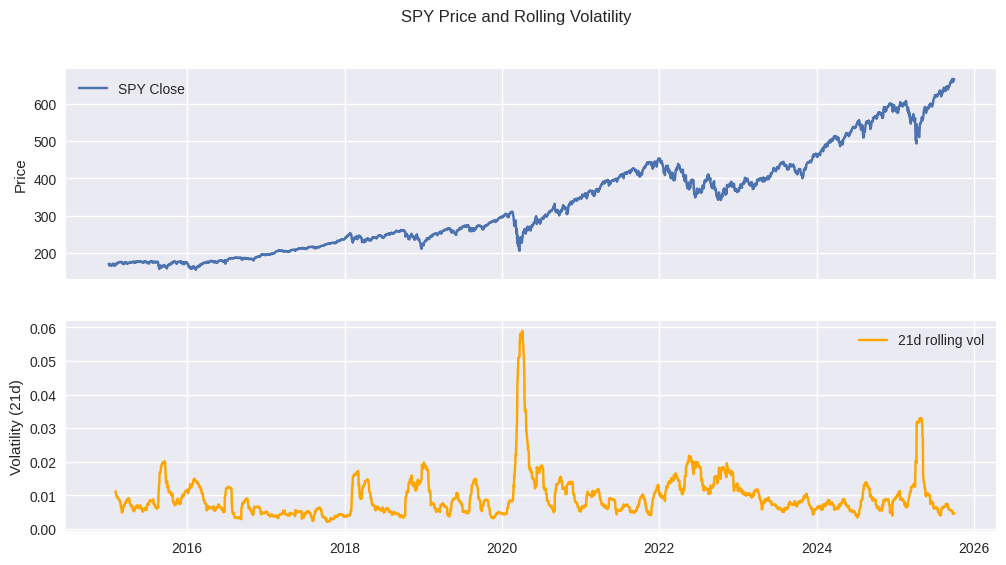

In [ ]:
# Cell 4: Plot price and monthly volatility for each ticker
import matplotlib.pyplot as plt
import seaborn as sns

for t, df in data.items():
    fig, axes = plt.subplots(2,1, figsize=(12,6), sharex=True)
    axes[0].plot(df.index, df['Close'], label=f'{t} Close')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[1].plot(df.index, df['Volatility_21'], color='orange', label='21d rolling vol')
    axes[1].set_ylabel('Volatility (21d)')
    axes[1].legend()
    plt.suptitle(f'{t} Price and Rolling Volatility')
    plt.show()

Basic statistics and missing data handling

In [ ]:
# Cell 5: Summary statistics and missing values
for t, df in data.items():
    print(f"\n--- {t} SUMMARY ---")
    display(df[['LogReturn','Volatility_21']].describe().T)
    na_counts = df[['LogReturn','Volatility_21']].isna().sum()
    print("Missing counts:", na_counts.to_dict())



--- AAPL SUMMARY ---


,,count,mean,std,min,25%,50%,75%,max
Price,Ticker,,,,,,,,
LogReturn,,2701.000000,0.000870,0.018292,-0.137708,-0.007426,0.000950,0.010068,0.142617
Volatility_21,,2681.000000,0.016533,0.007896,0.004897,0.011588,0.014879,0.019368,0.067330


Missing counts: {('LogReturn', ''): 1, ('Volatility_21', ''): 21}

--- TSLA SUMMARY ---


,,count,mean,std,min,25%,50%,75%,max
Price,Ticker,,,,,,,,
LogReturn,,2701.000000,0.001264,0.036419,-0.236518,-0.016677,0.001258,0.019394,0.204491
Volatility_21,,2681.000000,0.033596,0.013875,0.010593,0.023229,0.030911,0.040199,0.099168


Missing counts: {('LogReturn', ''): 1, ('Volatility_21', ''): 21}

--- SPY SUMMARY ---


,,count,mean,std,min,25%,50%,75%,max
Price,Ticker,,,,,,,,
LogReturn,,2701.000000,0.000503,0.011300,-0.115887,-0.003712,0.000608,0.005913,0.099863
Volatility_21,,2681.000000,0.009448,0.006335,0.002152,0.005740,0.007754,0.011695,0.059005


Missing counts: {('LogReturn', ''): 1, ('Volatility_21', ''): 21}


Stationarity check (ADF test) on returns & volatility

In [ ]:
# Cell 6: ADF test helper and results
def adf_test(series, title='Series'):
    series_clean = series.dropna()
    result = adfuller(series_clean, autolag='AIC')
    print(f"{title} - ADF Statistic: {result[0]:.6f}, p-value: {result[1]:.6f}")
    for key, val in result[4].items():
        print(f'  Critical Value ({key}): {val:.6f}')
    print('----')

for t, df in data.items():
    print(f"\nADF for {t} LogReturn:")
    adf_test(df['LogReturn'], title=f'{t} LogReturn')
    print(f"ADF for {t} Volatility_21:")
    adf_test(df['Volatility_21'], title=f'{t} Volatility_21')



ADF for AAPL LogReturn:
AAPL LogReturn - ADF Statistic: -16.746756, p-value: 0.000000
  Critical Value (1%): -3.432781
  Critical Value (5%): -2.862614
  Critical Value (10%): -2.567342
----
ADF for AAPL Volatility_21:
AAPL Volatility_21 - ADF Statistic: -5.879844, p-value: 0.000000
  Critical Value (1%): -3.432817
  Critical Value (5%): -2.862630
  Critical Value (10%): -2.567350
----

ADF for TSLA LogReturn:
TSLA LogReturn - ADF Statistic: -12.021142, p-value: 0.000000
  Critical Value (1%): -3.432791
  Critical Value (5%): -2.862618
  Critical Value (10%): -2.567344
----
ADF for TSLA Volatility_21:
TSLA Volatility_21 - ADF Statistic: -4.340739, p-value: 0.000377
  Critical Value (1%): -3.432813
  Critical Value (5%): -2.862628
  Critical Value (10%): -2.567349
----

ADF for SPY LogReturn:
SPY LogReturn - ADF Statistic: -16.752012, p-value: 0.000000
  Critical Value (1%): -3.432781
  Critical Value (5%): -2.862614
  Critical Value (10%): -2.567342
----
ADF for SPY Volatility_21:
SPY

ACF / PACF plots (for ARIMA identification)

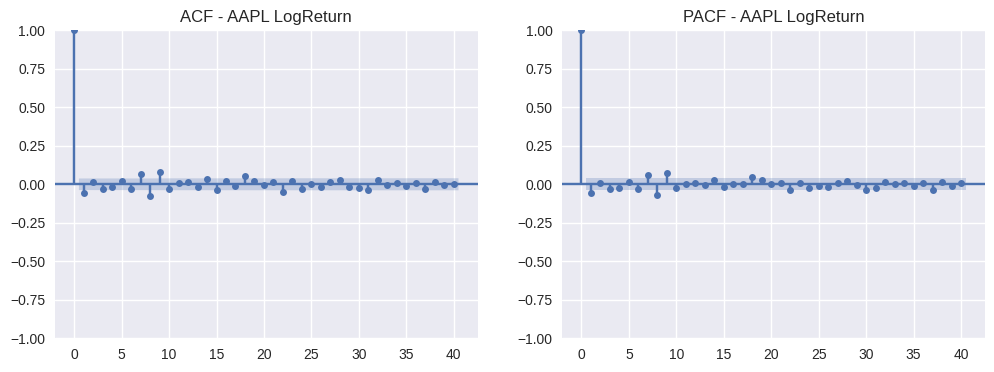

In [ ]:
# Cell 7: ACF and PACF for AAPL log returns
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Added import for plot_acf and plot_pacf
series = data['AAPL']['LogReturn'].dropna()
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(series, lags=40, ax=ax[0])
plot_pacf(series, lags=40, ax=ax[1])
ax[0].set_title('ACF - AAPL LogReturn')
ax[1].set_title('PACF - AAPL LogReturn')
plt.show()

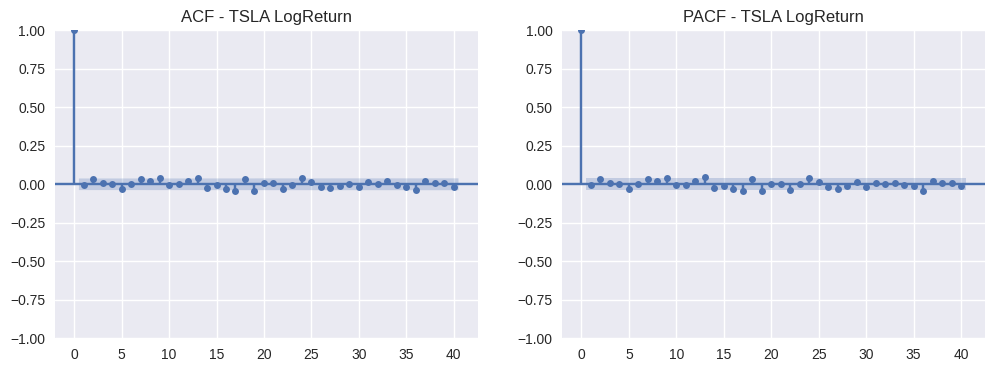

In [ ]:
series = data['TSLA']['LogReturn'].dropna()
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(series, lags=40, ax=ax[0])
plot_pacf(series, lags=40, ax=ax[1])
ax[0].set_title('ACF - TSLA LogReturn')
ax[1].set_title('PACF - TSLA LogReturn')
plt.show()

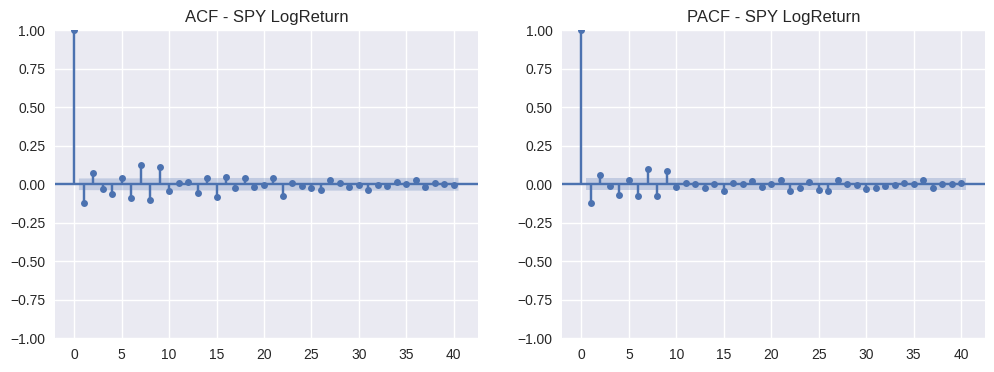

In [ ]:
series = data['SPY']['LogReturn'].dropna()
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(series, lags=40, ax=ax[0])
plot_pacf(series, lags=40, ax=ax[1])
ax[0].set_title('ACF - SPY LogReturn')
ax[1].set_title('PACF - SPY LogReturn')
plt.show()

Save cleaned dataset for later weeks

In [ ]:
# Cell 8: Save cleaned CSVs to Colab workspace or Google Drive (optional)
for t, df in data.items():
    out = df[['Close','LogReturn','Volatility_21','Volatility_7','Volume']].copy()
    out.dropna(inplace=True)   # we trim rows with NaNs to create clean files
    out.to_csv(f"{t}_clean.csv")
    print(f"Saved {t}_clean.csv with {len(out)} rows")


Saved AAPL_clean.csv with 2681 rows
Saved TSLA_clean.csv with 2681 rows
Saved SPY_clean.csv with 2681 rows


### Week 2

In [ ]:
!pip install -q pmdarima
!pip install -q arch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model

plt.style.use('seaborn-v0_8')

df = pd.read_csv("/content/drive/MyDrive/TSA/AAPL_clean.csv", index_col=0, parse_dates=True)
print(df.head())
print(df.index.name)


                         Close  LogReturn  Volatility_21  Volatility_7  \
Price                                                                    
Ticker                    AAPL        NaN            NaN           NaN   
Date                       NaN        NaN            NaN           NaN   
2015-02-03   26.30371856689453   0.000169       0.023072      0.029625   
2015-02-04   26.50545310974121   0.007640       0.021845      0.029510   
2015-02-05  26.694637298583984   0.007112       0.021810      0.022604   

               Volume  
Price                  
Ticker           AAPL  
Date              NaN  
2015-02-03  207662800  
2015-02-04  280598800  
2015-02-05  168984800  
Price


/tmp/ipython-input-1000199315.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("/content/drive/MyDrive/TSA/AAPL_clean.csv", index_col=0, parse_dates=True)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 2: Fit ARIMA on AAPL log returns
returns = df['LogReturn'].dropna()

model_arima = auto_arima(
    returns,
    seasonal=False,
    stepwise=True,
    trace=True,
    suppress_warnings=True,
    error_action='ignore'
)
model_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-13851.969, Time=4.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-13852.192, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-13857.737, Time=0.39 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-13857.523, Time=1.53 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-13856.308, Time=1.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-13856.498, Time=2.21 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-13854.256, Time=2.44 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-13862.160, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-13855.955, Time=1.47 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-13860.561, Time=4.87 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-13860.820, Time=1.41 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-13861.965, Time=1.36 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-13858.511, Time=3.09 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 24.989 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2681
Model:               SARIMAX(1, 0, 0)   Log Likelihood                6934.080
Date:                Sat, 29 Nov 2025   AIC                         -13862.160
Time:                        20:28:55   BIC                         -13844.479
Sample:                             0   HQIC                        -13855.764
                               - 2681                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.000      2.518      0.012       0.000       0.002
ar.L1         -0.0553      0.012     -4.762      0.000      -0.078      -0.033
sigma2         0.0003   4.79e-06     69.354      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4063.30
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
import pandas as pd

# Reload skipping only the first row (not two)
df = pd.read_csv("/content/drive/MyDrive/TSA/AAPL_clean.csv", skiprows=1)

# Rename the columns explicitly
df.columns = ['Date', 'Close', 'LogReturn', 'Volatility_21', 'Volatility_7', 'Volume']

# Drop any potential non-numeric header rows
df = df[df['Date'].str.contains('201', na=False)]  # keeps only actual date rows
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Convert numeric columns
df[['Close', 'LogReturn', 'Volatility_21', 'Volatility_7', 'Volume']] = df[
    ['Close', 'LogReturn', 'Volatility_21', 'Volatility_7', 'Volume']
].apply(pd.to_numeric, errors='coerce')

# Check cleaned result
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1237 entries, 2015-02-03 to 2019-12-31
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Close          1237 non-null   float64
 1   LogReturn      1237 non-null   float64
 2   Volatility_21  1237 non-null   float64
 3   Volatility_7   1237 non-null   float64
 4   Volume         1237 non-null   float64
dtypes: float64(5)
memory usage: 58.0 KB
None
               Close  LogReturn  Volatility_21  Volatility_7           Volume
Date                                                                         
2015-02-03 26.303719   0.000169       0.023072      0.029625 207662800.000000
2015-02-04 26.505453   0.007640       0.021845      0.029510 280598800.000000
2015-02-05 26.694637   0.007112       0.021810      0.022604 168984800.000000
2015-02-06 26.469849  -0.008456       0.021947      0.014831 174826400.000000
2015-02-09 26.645672   0.006620       0.020632      0.

In [ ]:
print(df.tail())


               Close  LogReturn  Volatility_21  Volatility_7           Volume
Date                                                                         
2019-12-24 68.588478   0.000950       0.010947      0.008306  48478800.000000
2019-12-26 69.949318   0.019646       0.011097      0.008999  93121200.000000
2019-12-27 69.922768  -0.000380       0.010813      0.009175 146266000.000000
2019-12-30 70.337769   0.005918       0.010626      0.008625 144114400.000000
2019-12-31 70.851692   0.007280       0.010548      0.008353 100805600.000000


In [ ]:
returns = df['LogReturn'].dropna()


In [ ]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

# Define target variable (stationary log returns)
returns = df['LogReturn'].dropna()

# Fit ARIMA model automatically
model_arima = auto_arima(
    returns,
    seasonal=False,
    stepwise=True,
    trace=True,
    suppress_warnings=True,
    error_action='ignore'
)

print(model_arima.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-6785.882, Time=1.70 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6791.379, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6789.538, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-6789.549, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6787.342, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-6792.675, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6790.768, Time=0.38 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6790.777, Time=0.89 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6788.563, Time=1.30 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 5.503 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1237
Model:                        SARIMAX   Log Likelihood                3398.337
Date:                Sat, 29 Nov 2025   

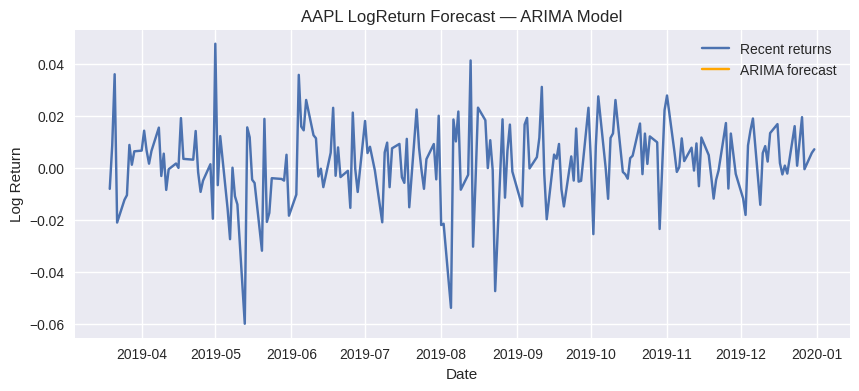

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Number of days to forecast
n_forecast = 30

# Predict next 30 periods
forecast_arima = model_arima.predict(n_periods=n_forecast)

# Build forecast index (30 business days after last date)
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1),
                               periods=n_forecast, freq='B')

forecast_series = pd.Series(forecast_arima, index=forecast_index)

# Plot
plt.figure(figsize=(10,4))
plt.plot(df.index[-200:], df['LogReturn'][-200:], label='Recent returns')
plt.plot(forecast_series, label='ARIMA forecast', color='orange')

plt.title("AAPL LogReturn Forecast — ARIMA Model")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.show()


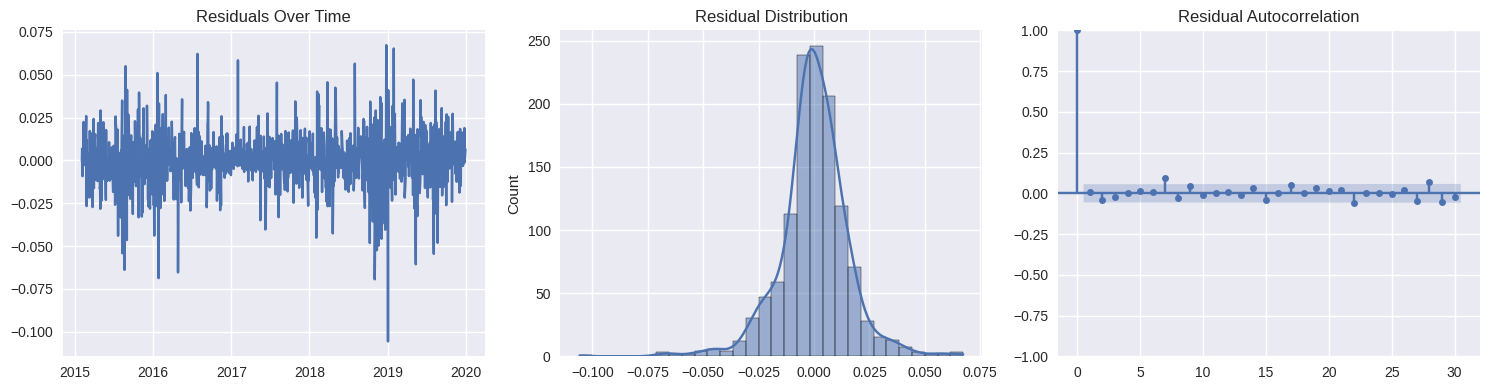

Jarque–Bera p-value: 0.0000


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Compute residuals (actual - predicted in-sample)
residuals = returns - model_arima.predict_in_sample()

fig, ax = plt.subplots(1,3, figsize=(15,4))

# 1️. Residual time plot
ax[0].plot(residuals)
ax[0].set_title("Residuals Over Time")

# 2️. Histogram + KDE
sns.histplot(residuals, bins=30, kde=True, ax=ax[1])
ax[1].set_title("Residual Distribution")

# 3️. ACF of residuals
plot_acf(residuals, lags=30, ax=ax[2])
ax[2].set_title("Residual Autocorrelation")

plt.tight_layout()
plt.show()

# Normality test
jb_stat, jb_p = stats.jarque_bera(residuals.dropna())
print(f"Jarque–Bera p-value: {jb_p:.4f}")


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Evaluate on last 30 observed points (if you want a small validation window)
n_test = 30
train = returns[:-n_test]
test = returns[-n_test:]

model_val = auto_arima(train, seasonal=False, suppress_warnings=True)
preds = model_val.predict(n_periods=n_test)

rmse = np.sqrt(mean_squared_error(test, preds))
print(f"Validation RMSE (last 30 days): {rmse:.6f}")


Validation RMSE (last 30 days): 0.010418


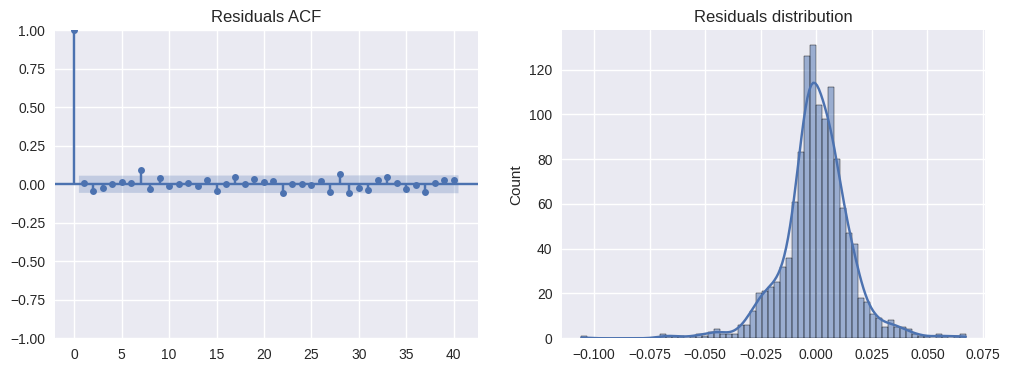

Residual mean: 5.026869875176649e-12
Residual std: 0.01551767714707309
Ljung-Box p-value: 3.160946079090322e-211


In [ ]:
# Cell 4: Diagnostic checks
from statsmodels.graphics.tsaplots import plot_acf
import scipy.stats as stats

residuals = model_arima.resid()

fig, ax = plt.subplots(1,2,figsize=(12,4))
plot_acf(residuals, lags=40, ax=ax[0])
ax[0].set_title("Residuals ACF")
sns.histplot(residuals, kde=True, ax=ax[1])
ax[1].set_title("Residuals distribution")
plt.show()

print("Residual mean:", residuals.mean())
print("Residual std:", residuals.std())
print("Ljung-Box p-value:", stats.jarque_bera(residuals)[1])


In [ ]:
# Cell 5: Fit GARCH model to returns
garch_model = arch_model(returns * 100, vol='GARCH', p=1, q=1, mean='Zero', dist='normal')
garch_fit = garch_model.fit(disp='off')
print(garch_fit.summary())


                       Zero Mean - GARCH Model Results                        
Dep. Variable:              LogReturn   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2237.84
Distribution:                  Normal   AIC:                           4481.68
Method:            Maximum Likelihood   BIC:                           4497.04
                                        No. Observations:                 1237
Date:                Sat, Nov 29 2025   Df Residuals:                     1237
Time:                        20:29:46   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1786  6.497e-02      2.748  5.987e-03 [5.123e-0

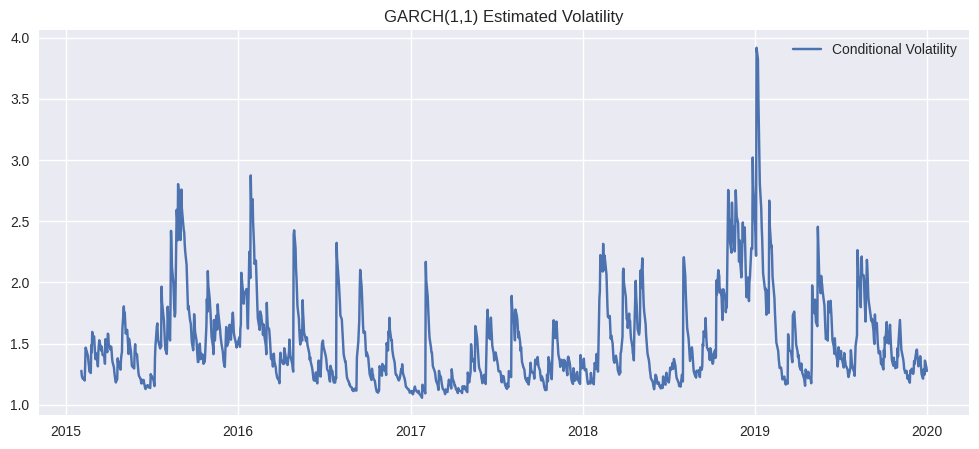

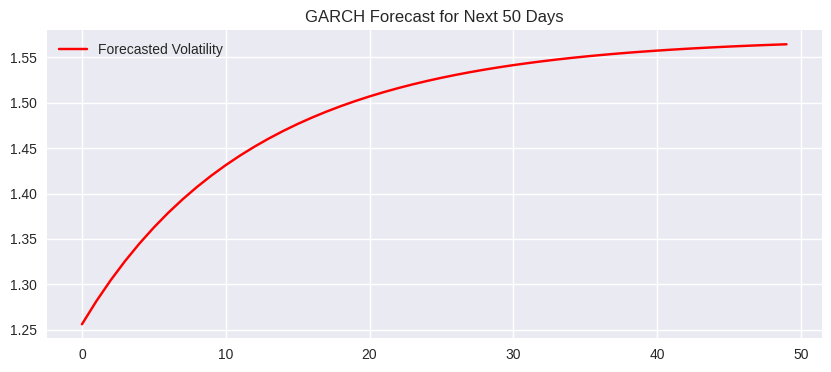

In [ ]:
# Cell 6: Forecast volatility
forecast_horizon = 50
garch_forecast = garch_fit.forecast(horizon=forecast_horizon, reindex=False)

cond_vol = garch_fit.conditional_volatility
plt.figure(figsize=(12,5))
plt.plot(cond_vol, label='Conditional Volatility')
plt.title("GARCH(1,1) Estimated Volatility")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(garch_forecast.variance.values[-1] ** 0.5, label='Forecasted Volatility', color='red')
plt.title("GARCH Forecast for Next 50 Days")
plt.legend()
plt.show()


Volatility RMSE: 0.3428


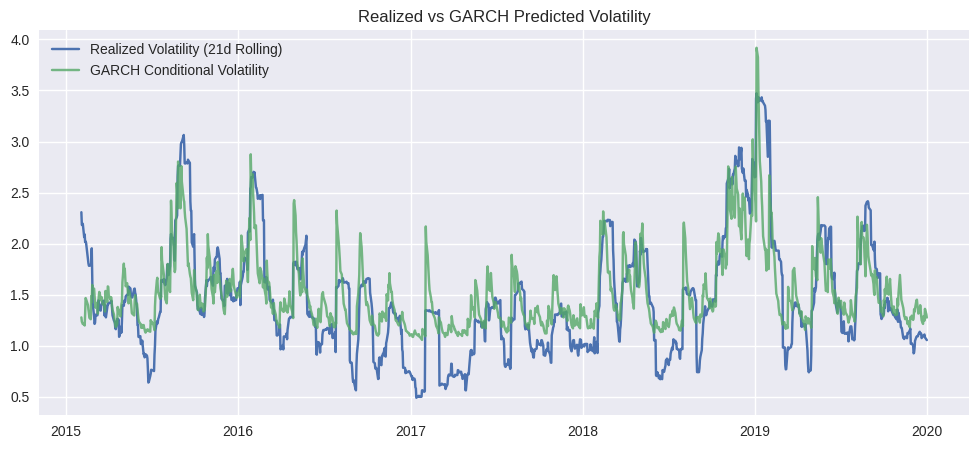

In [ ]:
# Cell 7: Realized vs predicted volatility (rolling RMSE)
realized_vol = df['Volatility_21'].dropna() * 100
predicted_vol = pd.Series(cond_vol, index=returns.index).dropna()

align_idx = realized_vol.index.intersection(predicted_vol.index)
rmse = np.sqrt(((realized_vol.loc[align_idx] - predicted_vol.loc[align_idx])**2).mean())

print(f"Volatility RMSE: {rmse:.4f}")

plt.figure(figsize=(12,5))
plt.plot(realized_vol.loc[align_idx], label='Realized Volatility (21d Rolling)')
plt.plot(predicted_vol.loc[align_idx], label='GARCH Conditional Volatility', alpha=0.8)
plt.legend()
plt.title("Realized vs GARCH Predicted Volatility")
plt.show()


In [ ]:
# Cell 8: Summarize baseline performance
summary = {
    'Ticker': 'AAPL',
    'ARIMA_order': model_arima.order,
    'ARIMA_AIC': model_arima.aic(),
    'GARCH_Alpha': garch_fit.params['alpha[1]'],
    'GARCH_Beta': garch_fit.params['beta[1]'],
    'GARCH_RMSE': rmse
}
pd.DataFrame([summary])


,Ticker,ARIMA_order,ARIMA_AIC,GARCH_Alpha,GARCH_Beta,GARCH_RMSE
0,AAPL,"(0, 0, 0)",-6792.674921,0.100886,0.826820,0.342814



================ AAPL =================
ARIMA order: (1, 0, 0)


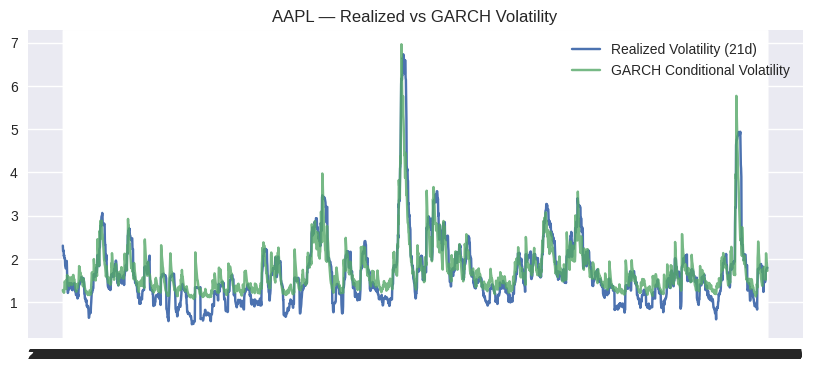


================ TSLA =================
ARIMA order: (0, 0, 0)


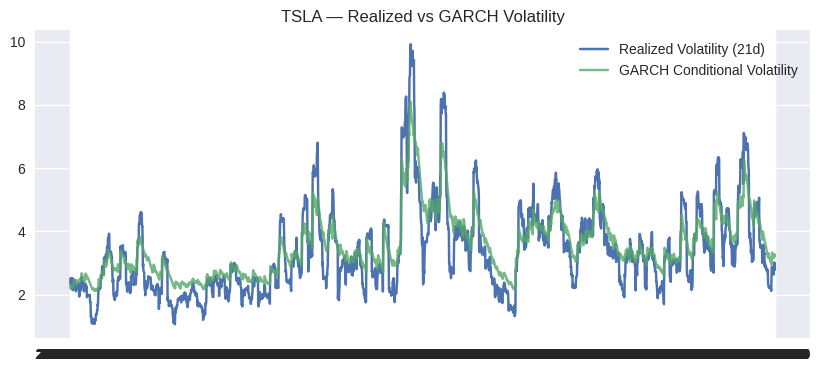


================ SPY =================
ARIMA order: (4, 0, 5)


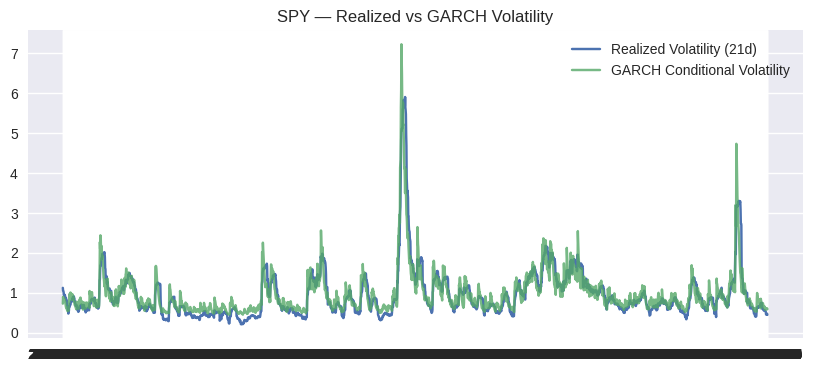

,Ticker,ARIMA_order,ARIMA_AIC,ARIMA_RMSE,GARCH_Alpha,GARCH_Beta,GARCH_RMSE
0,AAPL,"(1, 0, 0)",-13862.160368,0.015809,0.097860,0.855359,0.367099
1,TSLA,"(0, 0, 0)",-10139.913427,0.028933,0.033765,0.959032,0.655943
2,SPY,"(4, 0, 5)",-16547.853547,0.005219,0.166767,0.803850,0.268350


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pmdarima import auto_arima
from arch import arch_model
from sklearn.metrics import mean_squared_error

tickers = ['AAPL', 'TSLA', 'SPY']
results = []

for t in tickers:
    print(f"\n================ {t} =================")

    # Read from Google Drive folder
    df = pd.read_csv(f"/content/drive/MyDrive/TSA/{t}_clean.csv", index_col=0, parse_dates=True)
    returns = df['LogReturn'].dropna()

    # --- ARIMA ---
    model_arima = auto_arima(returns, seasonal=False, stepwise=True,
                             suppress_warnings=True, error_action='ignore')
    arima_order = model_arima.order
    print(f"ARIMA order: {arima_order}")

    # --- ARIMA RMSE (evaluate on last 30 days) ---
    n_test = 30
    train_arima = returns[:-n_test]
    test_arima  = returns[-n_test:]

    model_val = auto_arima(train_arima, seasonal=False, suppress_warnings=True)
    preds_arima = model_val.predict(n_periods=n_test)

    arima_rmse = np.sqrt(mean_squared_error(test_arima, preds_arima))


    # --- GARCH ---
    garch_model = arch_model(returns*100, vol='GARCH', p=1, q=1, mean='Zero')
    garch_fit = garch_model.fit(disp='off')

    # --- Volatility comparison ---
    realized_vol = df['Volatility_21'].dropna() * 100
    predicted_vol = pd.Series(garch_fit.conditional_volatility, index=returns.index)
    align_idx = realized_vol.index.intersection(predicted_vol.index)
    rmse = np.sqrt(mean_squared_error(realized_vol.loc[align_idx],
                                      predicted_vol.loc[align_idx]))


    results.append({
    "Ticker": t,

    # ARIMA
    "ARIMA_order": arima_order,
    "ARIMA_AIC": model_arima.aic(),
    "ARIMA_RMSE": arima_rmse,

    # GARCH
    "GARCH_Alpha": garch_fit.params.get('alpha[1]', np.nan),
    "GARCH_Beta": garch_fit.params.get('beta[1]', np.nan),
    "GARCH_RMSE": rmse
})



    # --- Plot each ticker’s volatility comparison ---
    plt.figure(figsize=(10,4))
    plt.plot(realized_vol.loc[align_idx], label="Realized Volatility (21d)")
    plt.plot(predicted_vol.loc[align_idx], label="GARCH Conditional Volatility", alpha=0.8)
    plt.title(f"{t} — Realized vs GARCH Volatility")
    plt.legend()
    plt.show()

summary_df = pd.DataFrame(results)
display(summary_df)


In [ ]:
# SAVE ARIMA + GARCH RESULTS DICTS FOR WEEK 4

arima_results = {}
garch_results = {}

for row in results:
    t = row["Ticker"]

    # ARIMA dictionary
    arima_results[t] = {
        "order": row["ARIMA_order"],
        "aic": row["ARIMA_AIC"],
        "rmse": row["ARIMA_RMSE"] if "ARIMA_RMSE" in row else None
    }

    # GARCH dictionary
    garch_results[t] = {
        "alpha": row["GARCH_Alpha"],
        "beta": row["GARCH_Beta"],
        "rmse": row["GARCH_RMSE"]
    }

# Save to drive so Week-4 notebook can load them
import pickle

with open("/content/drive/MyDrive/TSA/arima_results.pkl", "wb") as f:
    pickle.dump(arima_results, f)

with open("/content/drive/MyDrive/TSA/garch_results.pkl", "wb") as f:
    pickle.dump(garch_results, f)

print("Saved: arima_results.pkl and garch_results.pkl")


Saved: arima_results.pkl and garch_results.pkl


In [ ]:
import pickle

with open("/content/drive/MyDrive/TSA/arima_results.pkl", "rb") as f:
    arima = pickle.load(f)

print(type(arima))
print(arima.keys() if isinstance(arima, dict) else arima)


<class 'dict'>
dict_keys(['AAPL', 'TSLA', 'SPY'])


Convert from .pkl to .csv

In [ ]:
import pandas as pd
import pickle

with open("/content/drive/MyDrive/TSA/arima_results.pkl", "rb") as f:
    arima = pickle.load(f)

rows = []
for symbol, result in arima.items():
    if isinstance(result, dict):
        row = {"symbol": symbol}
        for k, v in result.items():
            row[k] = v
        rows.append(row)

df = pd.DataFrame(rows)
df.to_csv("/content/drive/MyDrive/TSA/arima_readable.csv", index=False)


In [ ]:
import pandas as pd
import pickle

with open("/content/drive/MyDrive/TSA/garch_results.pkl", "rb") as f:
    garch = pickle.load(f)

rows = []
for symbol, result in arima.items():
    if isinstance(result, dict):
        row = {"symbol": symbol}
        for k, v in result.items():
            row[k] = v
        rows.append(row)

df = pd.DataFrame(rows)
df.to_csv("/content/drive/MyDrive/TSA/garch_readable.csv", index=False)
